# **PHẦN 2: MÔ HÌNH HOÁ DỮ LIỆU**

## **1. Import các packages cần thiết**

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime 
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings("ignore")

## **2. Đọc dữ liệu từ file csv**

In [184]:
df = pd.read_csv('./features/processed.csv')
df.shape

(48291, 24)

In [185]:
df.sample(5)

,id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,review_count,inventory_type,productset_group_name,day_ago_created,categories,all_time_quantity_sold,authors,publisher_vn,publication_date,dimensions,manufacturer,number_of_page,dich_gia,edition,luu_y
18954,136126085,3730005975999,Combo 6 cuốn sách Ehon Song Ngữ Kích Thích Thị...,https://tiki.vn/product-p136126085.html?spid=1...,NaN,105000,135000,22,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách thiếu nhi /...,396,Truyện tranh Ehon,28,NaN,Công ty CP in Thương Mại Nam Hải,NaN,NaN,Nhà Xuất Bản Hà Nội,0,NaN,NaN,NaN
27340,95335078,2495698391798,Các Phương Pháp Công Cụ Trong Hóa Phân Tích Hữ...,https://tiki.vn/product-p95335078.html?spid=95...,Bìa mềm,72000,75000,4,4.8,11,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Giáo Khoa -...,575,Giáo Trình Đại Học - Cao Đẳng,28,Trần Mạnh Trí,Nhà Xuất Bản Đại Học Quốc Gia Hà Nội,2021-01-14 16:44:34,NaN,Nhà Xuất Bản Đại Học Quốc Gia Hà Nội,258,NaN,Lần thứ nhất,NaN
22851,116409047,5666578912088,Combo Sách kỹ năng sống làm thay đổi cuộc đời ...,https://tiki.vn/product-p116409047.html?spid=1...,NaN,211000,248000,15,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách kỹ năng sốn...,487,Sách nghệ thuật sống đẹp,0,NaN,Skybooks,NaN,NaN,Nhà Xuất Bản Thế Giới,0,NaN,NaN,NaN
42383,88881362,2354686480378,Bảo Tánh Luận ( Bìa Mềm ),https://tiki.vn/product-p88881362.html?spid=10...,Bìa mềm,49000,49000,0,5.0,1,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Tôn Giáo - ...,601,Sách Tôn Giáo - Tâm Linh,24,NaN,DT Books,2021-03-01 07:07:07,NaN,Nhà Xuất Bản Tôn Giáo,192,Bồ Tát Di Lặc,NaN,NaN
23950,202857872,2963943200662,"Sách Không Phải Trong Dông Bão, Ta Đang Sống N...",https://tiki.vn/product-p202857872.html?spid=2...,NaN,98000,98000,0,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách kỹ năng sốn...,38,Sách hướng nghiệp - Kỹ năng mềm,0,NaN,Skybooks,NaN,NaN,Nhà Xuất Bản Hà Nội,0,NaN,NaN,NaN


## **3. Xác định câu hỏi cần trả lời:**
**Bài toán dự đoán `discount_rate` dựa trên các đặc trưng của sản phẩm.**
- Đây là một bài toán hồi quy.
- Input là các đặc trưng ảnh hưởng đến tỉ lệ giảm giá của một mặt hàng sách.
- Output là tỉ lệ giảm giá của sách. 

**Trả lời được câu hỏi này sẽ giúp cho cả khách hàng và nhà bán có những lợi ích sau:**
- Nhà bán quyết định mức sale phù hợp với thị trường, từ đó bán được nhiều sản phẩm hơn.
- Người mua chọn được sản phẩm giá rẻ, có mức sale cao, dựa vào việc xem xét qua các đặc trưng khác.

## **4. Phân tích, xử lý và chuẩn bị dữ liệu cho bước mô hình hoá**

Các cột có kiểu dữ liệu là numeric 

In [186]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols

Index(['id', 'sku', 'price', 'original_price', 'discount_rate',
       'rating_average', 'review_count', 'day_ago_created',
       'all_time_quantity_sold', 'number_of_page'],
      dtype='object')

In [187]:
numeric_profiles = {'missing_ratio': df[numeric_cols].isna().sum() * 100.0/len(df[numeric_cols]),
                        'min': df[numeric_cols].min(),
                        'max': df[numeric_cols].max()}
nume_col_profiles_df = pd.DataFrame(numeric_profiles).transpose()
nume_col_profiles_df

,id,sku,price,original_price,discount_rate,rating_average,review_count,day_ago_created,all_time_quantity_sold,number_of_page
missing_ratio,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
min,148562.0,1.000110e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
max,207990688.0,9.999995e+12,6000000.0,6950000.0,91.0,5.0,6306.0,2689.0,32323.0,9.786049e+12


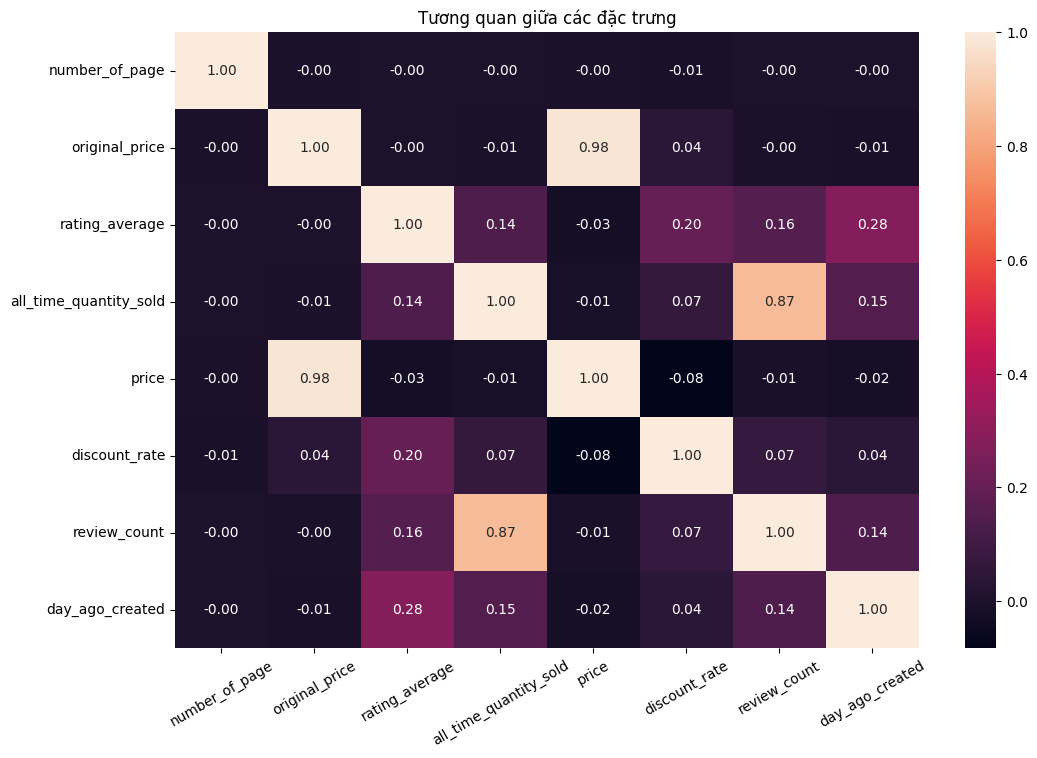

In [188]:
plt.figure(figsize=(12,8))
sns.heatmap(df[set(numeric_cols) - {'id', 'sku'}].corr(), annot=True, fmt='.2f')
plt.xticks(rotation=30)
plt.title('Tương quan giữa các đặc trưng')
plt.show()

In [189]:
cate_cols = set(df.columns) - set(numeric_cols)
cate_profiles = {'missing_ratio': df[cate_cols].isna().sum() * 100.0/len(df[cate_cols]),
               #   'zero_values_ratio':  df[cate_cols].eq(0).sum(axis=1) * 100.0/len(df[cate_cols]),
                      'num_diff_vals': df[cate_cols].nunique(dropna=True),
                      'diff_vals': df[cate_cols].stack(dropna=True).groupby(level=[1]).unique(),
                      }
cate_col_profiles_df = pd.DataFrame(cate_profiles).transpose()
cate_col_profiles_df

,authors,book_cover,categories,dich_gia,dimensions,edition,inventory_type,luu_y,manufacturer,name,productset_group_name,publication_date,publisher_vn,short_url
missing_ratio,48.804125,35.358555,0.0,85.686774,82.744197,96.931105,0.0,99.995858,0.550827,0.0,0.0,61.158394,0.035203,0.0
num_diff_vals,9094,17,100,3110,1051,364,3,1,168,44424,101,10896,852,48288
diff_vals,"[Trần Đặng Đăng Khoa, Trần Hồng Ngọc, Lê Quang...","[Bìa mềm, Bìa Da, Bìa cứng, Bìa gập, Bìa rời, ...","[Du ký, Light novel, Phê Bình - Lý Luận Văn Họ...","[Khánh Vân, Phan Quang, Nguyễn Thị Bạch Tuyết,...","[13 x 20, 14,5 x 20,5 cm, 13.5 x 20.5 cm, 15 x...","[bìa mềm, BÌA MỀM, Tiếng Việt, Tặng kèm bookma...","[instock, backorder, preorder]",[Sách không còn kèm CD mà thay bằng ứng dụng t...,"[NXB Trẻ, Nhà Xuất Bản Lao Động, Nhà Xuất Bản ...",[1111 - Nhật Ký Sáu Vạn Dặm Trên Yên Xe Cà Tàn...,[Nhà Sách Tiki/Sách tiếng Việt/Sách văn học/Du...,"[2022-11-10 00:00:00, 2022-11-11 17:44:46, 202...","[NXB Trẻ, Chibooks, Văn Lang, Edibooks, NXB Ph...",[https://tiki.vn/product-p204317934.html?spid=...


In [193]:
cate_col_profiles_df.loc['diff_vals', 'categories']

array(['Du ký', 'Light novel', 'Phê Bình - Lý Luận Văn Học',
       'Phóng sự - Ký sự - Bút ký', 'Tác phẩm kinh điển', 'Thơ',
       'Tiểu sử - Hồi ký', 'Tiểu Thuyết',
       'Truyện Giả tưởng - Huyền Bí - Phiêu Lưu', 'Tranh Truyện',
       'Truyện cổ tích - Ngụ ngôn', 'Truyện cười', 'Truyện dài',
       'Bài học kinh doanh', 'Truyện đam mỹ', 'Truyện kiếm hiệp',
       'Truyện kinh dị', 'Truyện ngắn - Tản văn - Tạp Văn',
       'Truyện ngôn tình', 'Truyện trinh thám', 'Ca dao - Tục ngữ',
       'Sách ảnh', 'Sách doanh nhân', 'Sách khởi nghiệp',
       'Sách kinh tế học', 'Sách kỹ năng làm việc',
       'Sách Marketing - Bán hàng ', 'Sách quản trị, lãnh đạo',
       'Sách quản trị nhân lực', 'Sách tài chính, kế toán',
       'Sách tài chính, tiền tệ', 'Đạo đức - Kỹ năng sống',
       'Kiến thức - Bách khoa', 'Tô màu - Luyện chữ  ', 'Truyện cổ tích',
       'Truyện kể cho bé', 'Truyện tranh Ehon', 'Truyện tranh thiếu nhi',
       'Văn học thiếu nhi', 'Sách tư duy - Kỹ năng sống',
       

Chọn ra các features phù hợp/ có ảnh hưởng đến yêu cầu bài toán làm đầu vào cho mô hình 

In [194]:
cols = ['original_price', 'discount_rate',
       'rating_average', 'review_count', 'day_ago_created',
       'all_time_quantity_sold', 'number_of_page']
# Thêm một vài cột categories có ý nghĩa đối với output
cate = ['book_cover', 'categories', 'inventory_type', 'manufacturer', 'publication_date']
cols.extend(cate)

Xem qua kiểu dữ liệu của các cột

In [195]:
df[cols].dtypes

original_price              int64
discount_rate               int64
rating_average            float64
review_count                int64
day_ago_created             int64
all_time_quantity_sold      int64
number_of_page              int64
book_cover                 object
categories                 object
inventory_type             object
manufacturer               object
publication_date           object
dtype: object

In [196]:
df[['categories', 'inventory_type', 'manufacturer']] = df[['categories', 'inventory_type', 'manufacturer']].astype(str)
df[['categories', 'inventory_type', 'manufacturer']]

,categories,inventory_type,manufacturer
0,Du ký,instock,NXB Trẻ
1,Du ký,backorder,NXB Trẻ
2,Du ký,instock,Nhà Xuất Bản Lao Động
3,Du ký,backorder,Nhà Xuất Bản Hồng Đức
4,Du ký,backorder,NXB Trẻ
...,...,...,...
48286,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Hà Nội
48287,Thể Dục - Thể Thao,backorder,NXB Trẻ
48288,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Đại Học Quốc Gia Hà Nội
48289,Thể Dục - Thể Thao,backorder,Nhà Xuất Bản Thể Thao Và Du Lịch


Cột `publication_date` đang có kiểu dữ liệu là object, ta cũng cần chuyển về datetime cho phù hợp

In [197]:
df['publication_date'] = pd.to_datetime(df.publication_date, format = "%Y-%m-%d %H:%M:%S", errors = "coerce")

Có lẽ ta không cần cột này trong đầu vào của mô hình vì cột `day_ago_created` đã có ý nghĩa tương tự

In [198]:
cols.remove('publication_date')

**Xem một vài phân bố của các đặc trưng, từ đó giúp ta quan sát outliers, độ tập trung của dữ liệu**

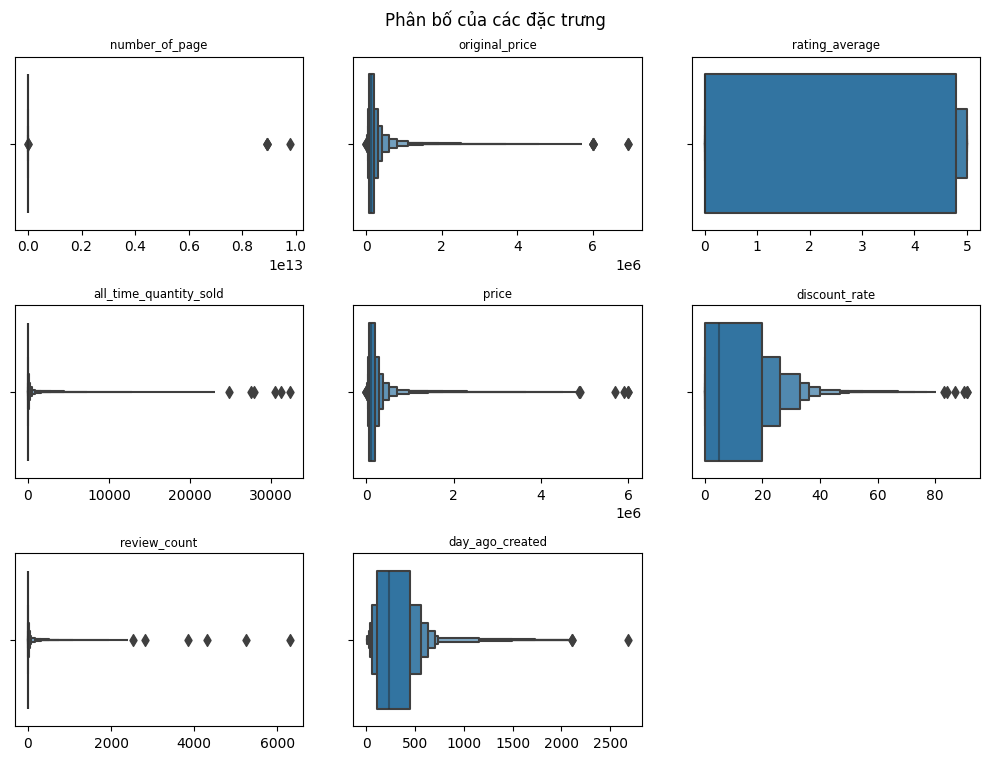

In [199]:
# df_cont = df.select_dtypes([int,float]) 
numeric_df = df[set(numeric_cols) - {'id', 'sku'}]

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Phân bố của các đặc trưng')
for i,col in enumerate(numeric_df.columns, 1): 
    ax = plt.subplot(4,3,i) 
    sns.boxenplot(data = numeric_df, x=numeric_df[col]) 
    plt.xlabel(None)
    plt.title(col, fontsize='small')
    plt.tight_layout(w_pad=3) 

plt.show() 

Hầu như các cột dữ liệu đều bị lệch phải (right-skewed)
- <font color=bone>*original_price*</font> và <font color=bone>*price*</font> có phân bố khá giống nhau, có vài điểm outliers khá lớn
- <font color=bone>*day_ago_created*</font> thì phân bố tập trung trong khoảng 0-500 và giảm dần về 2000
- <font color=bone>*rating_average*</font> phân bố khá đồng đều từ 0 đến 5
- <font color=bone>*all_time_quantity_sold*</font> phân bố chủ yếu ở giá trị 0, xấp xỉ 0 và rải rác từ 0 đến hơn 30000
- <font color=bone>*review_count*</font> cũng tương tự, tuy nhiên nằm rải rác từ 0 đến hơn 6000
- <font color=bone>*discount_rate*</font> chủ yếu phân bố từ 0-40 và thưa thớt ở các giá trị rate cao hơn
- Riêng với <font color=bone>*number_of_page*</font> có outlier khá "khủng" nên ta sẽ xử lý riêng và vẽ lại biểu đồ của cột này

Text(0.5, 1.0, 'Phân bố của number_of_page sau khi clip các giá trị ngoại lệ')

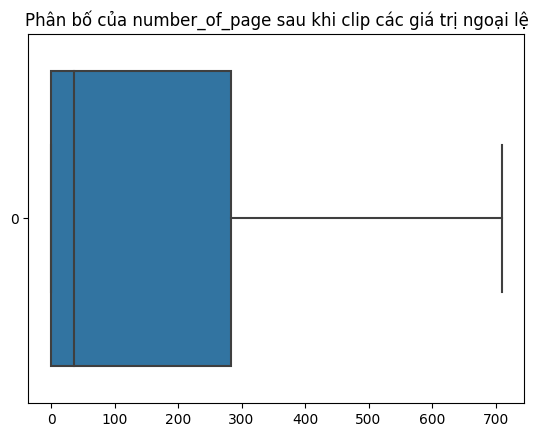

In [200]:
# ref: https://machinelearningcoban.com/tabml_book/ch_data_processing/process_outliers.html
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin
def find_boundaries(col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper

class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

numeric_df['number_of_page_clipped'] = BoxplotOutlierClipper().fit_transform(numeric_df['number_of_page'])
# print(numeric_df['number_of_page'].sort_values(ascending=False)[30:60])
sns.boxplot(data = numeric_df['number_of_page_clipped'].reset_index(drop=True)
              , orient='h')
plt.title('Phân bố của number_of_page sau khi clip các giá trị ngoại lệ') 
# plt.xlim(0, 1e4)

**Các cột có giá trị thiếu hay không? Nếu thiếu thì xử lý như thế nào?**

In [201]:
df[cols].isna().sum()

original_price                0
discount_rate                 0
rating_average                0
review_count                  0
day_ago_created               0
all_time_quantity_sold        0
number_of_page                0
book_cover                17075
categories                    0
inventory_type                0
manufacturer                  0
dtype: int64

Cột `book_cover` thiếu khá nhiều, ta sẽ xem qua các giá trị của cột này

In [202]:
df['book_cover'].value_counts()

Bìa mềm                                     27766
Bìa cứng                                     2922
Bìa gập                                       366
Bìa Da                                         43
Bìa rời                                        26
B Format Paperback                             22
Bìa Da Công Nghiệp Microfiber                  21
Box                                            14
Boxset                                         12
Tùy chọn phiên bản bìa cứng hoặc bìa mềm        9
Paperback                                       7
Board book                                      2
Mix Media Pack                                  2
Jigsaw box                                      1
Counterpack holds 48 Mini Activity Books        1
B-format Paperback                              1
Hardcover                                       1
Name: book_cover, dtype: int64

Ngoài ra, cột <font color=bone>number_of_page</font> chứa các giá trị 0 cũng khá vô lý (cuốn sách có 0 trang?), một suy đoán cho những giá trị này có thể là do thiếu dữ liệu về số trang nên sẽ mặc định là 0. 
- Có thể phải bỏ các dòng có giá trị này để tránh thêm vào điểm dữ liệu bất hợp lý?
- Một cách khác là điền vào các giá trị theo mật độ xuất hiện của các giá trị đã biết?

In [203]:
df[df['book_cover'].isna()].sample(5)

,id,sku,name,short_url,book_cover,price,original_price,discount_rate,rating_average,review_count,inventory_type,productset_group_name,day_ago_created,categories,all_time_quantity_sold,authors,publisher_vn,publication_date,dimensions,manufacturer,number_of_page,dich_gia,edition,luu_y
34407,106756769,6478538071073,Bộ 5 Cuốn 10 Vạn Câu Hỏi Vì Sao,https://tiki.vn/product-p106756769.html?spid=1...,NaN,160000,160000,0,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Kiến Thức T...,534,Kiến Thức Bách Khoa,6,NaN,Công ty TNHH ĐT và PT Văn hóa Việt - NS Trí Đức,NaT,NaN,Nhà Xuất Bản Hồng Đức,0,NaN,NaN,NaN
24111,167614017,7023218465668,Lựa Chọn Nhiệm Màu - Thông Điệp Mới Truyền Cảm...,https://tiki.vn/product-p167614017.html?spid=1...,NaN,83600,88000,5,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách kỹ năng sốn...,271,Sách hướng nghiệp - Kỹ năng mềm,0,NaN,First News - Trí Việt,NaT,NaN,oem,0,NaN,NaN,NaN
32056,113000402,5748069579248,Tự Ôn Tập Thi Tuyến Sinh Lớp 10 Môn Ngữ Văn,https://tiki.vn/product-p113000402.html?spid=1...,NaN,47500,50000,5,3.0,1,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Tham Khảo/S...,506,Sách tham khảo cấp II,3,"Nhiều Tác Giả, Nhiều Tác Giả, Nhiều tác giả, N...",Cty Đầu Tư & Phát Triển Giáo Dục Sài Gòn,NaT,NaN,Nhà Xuất Bản Đại Học Sư Phạm,0,NaN,NaN,NaN
33876,174827263,4617688472958,207 đề và bài văn hay 5,https://tiki.vn/product-p174827263.html?spid=1...,NaN,48000,69000,30,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách Tham Khảo/S...,232,Sách chuyên đề,0,NaN,Cty Văn Hóa Sách Việt,NaT,NaN,oem,0,NaN,NaN,NaN
15316,201856107,2901108426515,Sách Chiến lược Influencer Marketing,https://tiki.vn/product-p201856107.html?spid=2...,NaN,119200,149000,20,0.0,0,backorder,Nhà Sách Tiki/Sách tiếng Việt/Sách kinh tế/Sác...,44,"Sách tài chính, tiền tệ",0,NaN,1980 Books,NaT,NaN,Nhà Xuất Bản Dân Trí,0,NaN,NaN,NaN


Thay các giá trị 0 thành nan để phục vụ cho giai đoạn xử lý missing value 

In [204]:
df['number_of_page'].replace(0, np.nan, inplace=True)

### **Xử lý các giá trị ngoại lệ**

In [205]:
df['number_of_page'] = BoxplotOutlierClipper().fit_transform(df['number_of_page'])

In [206]:
features = df[cols].copy()

#### **Phân chia tập train/val/test**

In [207]:
x_df = features[set(cols) - {'discount_rate'}]
y_df = features['discount_rate']

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=5) # Tách tập test/train
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=5) # Tách tập train/val từ tập train


#### **Pipeline cho bước tiền xử lý**

In [208]:
# df['book_cover'].fillna('Không có bìa', inplace=True)
cate = [ 'book_cover', 'categories','inventory_type', 'manufacturer']
nume = ['original_price', 'rating_average', 'review_count', 'day_ago_created','all_time_quantity_sold',
        'number_of_page']

# Pipeline xử lý cho các cột category
cate_transformer = Pipeline(steps= [('imputer', SimpleImputer(strategy='most_frequent')), # Thay thế missing value bằng giá trị có tần suất xuất hiện cao
                               ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))]) # biểu diễn one hot cho các cột category
                                                                                # đối với các giá trị mà model chưa từng thấy bao giờ (trong tập test) thì ta bỏ qua
# Pipeline xử lý cho các cột numeric
nume_transfomer = Pipeline(steps= [('imputer', KNNImputer(n_neighbors=10)), # thay thế missing value bằng thuật toán k-nearest với số lượng láng giềng là 10
                                   ('scaler', MinMaxScaler())])  # scale các giá trị về miền giá trị trong khoảng 0 đến 1 

# Pipeline cho bước tiền xử lý chung 
preprocessor = ColumnTransformer(transformers=[('cate_transformer', cate_transformer, cate),
                                                ('nume_transfomer',nume_transfomer, nume)])

## **5. Huấn luyện mô hình**

#### **Linear Regression**

In [209]:
model = LinearRegression()
comp_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('linear_regression', model)])


comp_pipeline.fit(x_train, y_train)
y_train_pred = comp_pipeline.predict(x_train)

In [210]:
y_test_pred = comp_pipeline.predict(x_test)

In [211]:
print(f'Train set: [MSE: {mean_squared_error(y_train, y_train_pred):.3f}, MAE: {mean_absolute_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MSE: {mean_squared_error(y_test, y_test_pred):.3f}, MAE: {mean_absolute_error(y_test, y_test_pred):.3f}]')


Train set: [MSE: 108.656, MAE: 8.093]
Test set: [MSE: 109.089, MAE: 8.093]


Mô hình này cho ra độ lỗi khá tốt

#### **Cross validation**

In [212]:
# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regression', LinearRegression())])

scores = cross_val_score(completed_pl, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, error_score='raise')
 

In [213]:
print('Mean MAE: {:.03f}, Std: {:.03f}'.format(np.mean(scores, dtype=np.float64), np.std(scores)))

Mean MAE: -8.152, Std: 0.057


#### **Đánh giá nhiều mô hình với nhiều metric khác nhau**

In [214]:
models = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor(), TransformedTargetRegressor()]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

all_scores = []
metric = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for model in models:
  completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regression', model)]
  )

  scores = cross_validate(completed_pl, x_train, y_train, scoring=metric, cv=cv)
  print(str(model) + ' done!')
  all_scores.append(scores)

LinearRegression() done!
RandomForestRegressor() done!
GradientBoostingRegressor() done!
TransformedTargetRegressor() done!


In [215]:
all_scores_df = pd.DataFrame(all_scores)
# os.mkdir('./evaluating')
all_scores_df.to_csv('./evaluating/all_scores_2.csv', index_label=False)
all_scores_df.head()

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error
0,"[23.312170028686523, 22.876126766204834, 22.98...","[2.395737886428833, 2.393214225769043, 2.45576...","[-108.49431020998469, -110.61168466203866, -11...","[-8.068175005041342, -8.176933494496154, -8.19...","[-10.416060205758447, -10.517208976816931, -10...","[-1.5807477747016212e+16, -1.5958350179071636e..."
1,"[184.1718807220459, 181.8738989830017, 183.235...","[2.513406753540039, 2.512331008911133, 2.54115...","[-86.00159129069658, -83.7345231017329, -87.11...","[-6.610416148807536, -6.510329628227904, -6.65...","[-9.273704291743218, -9.150656976509003, -9.33...","[-1.1500228791554498e+16, -1.148519984985426e+..."
2,"[26.608525037765503, 26.215320348739624, 26.47...","[2.3495771884918213, 2.4147627353668213, 2.451...","[-108.16637771813022, -110.26080413748359, -11...","[-8.3321176586201, -8.428623314242971, -8.4651...","[-10.400306616544063, -10.500514470133528, -10...","[-1.6448658196644306e+16, -1.6579092606309984e..."
3,"[23.164755821228027, 22.792680501937866, 22.93...","[2.3884265422821045, 2.430955410003662, 2.4752...","[-108.49431020998469, -110.61168466203866, -11...","[-8.068175005041342, -8.176933494496154, -8.19...","[-10.416060205758447, -10.517208976816931, -10...","[-1.5807477747016212e+16, -1.5958350179071636e..."


Tính mean và standard deviation của từng giá trị trong `all_scores_df`

In [241]:
models = ['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'TransformedTargetRegressor']
def get_mean_std(x):
    return x.mean(), x.std()

all_scores_df.index = models
all_scores_df.applymap(get_mean_std)

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error
LinearRegression,"(23.109579157829284, 0.16926244182368733)","(2.440258995691935, 0.06592849870651057)","(-110.26660911992305, 1.608490562922346)","(-8.152232468420163, 0.05723434077172916)","(-10.500511684441957, 0.07657339499468194)","(-1.5833819243690518e+16, 225181131234008.78)"
RandomForestRegressor,"(182.87535212834675, 0.981111731535767)","(2.5250494480133057, 0.05029153834398033)","(-84.1534765538921, 2.311366045233903)","(-6.5542600152863075, 0.09246448172290758)","(-9.172652091628594, 0.12621473699094893)","(-1.144544918703714e+16, 263220264700897.3)"
GradientBoostingRegressor,"(26.533608690897623, 0.20741685372344104)","(2.4252702792485556, 0.04344605700192196)","(-109.16312969486415, 1.4044267952642726)","(-8.362560233774358, 0.051281974292333166)","(-10.447900209135417, 0.06716334426018852)","(-1.6354739970187866e+16, 160030219922749.16)"
TransformedTargetRegressor,"(23.04924136797587, 0.18316851613277468)","(2.431480956077576, 0.0487366018024075)","(-110.26660911992305, 1.608490562922346)","(-8.152232468420163, 0.05723434077172916)","(-10.500511684441957, 0.07657339499468194)","(-1.5833819243690518e+16, 225181131234008.78)"


Dựa vào bảng có thể thấy mô hình <font color=bone>RandomForest</font> cho độ lỗi tốt nhất, tuy nhiên <font color=bone>fit_time</font> và <font color=bone>score_time</font> là cao nhất.

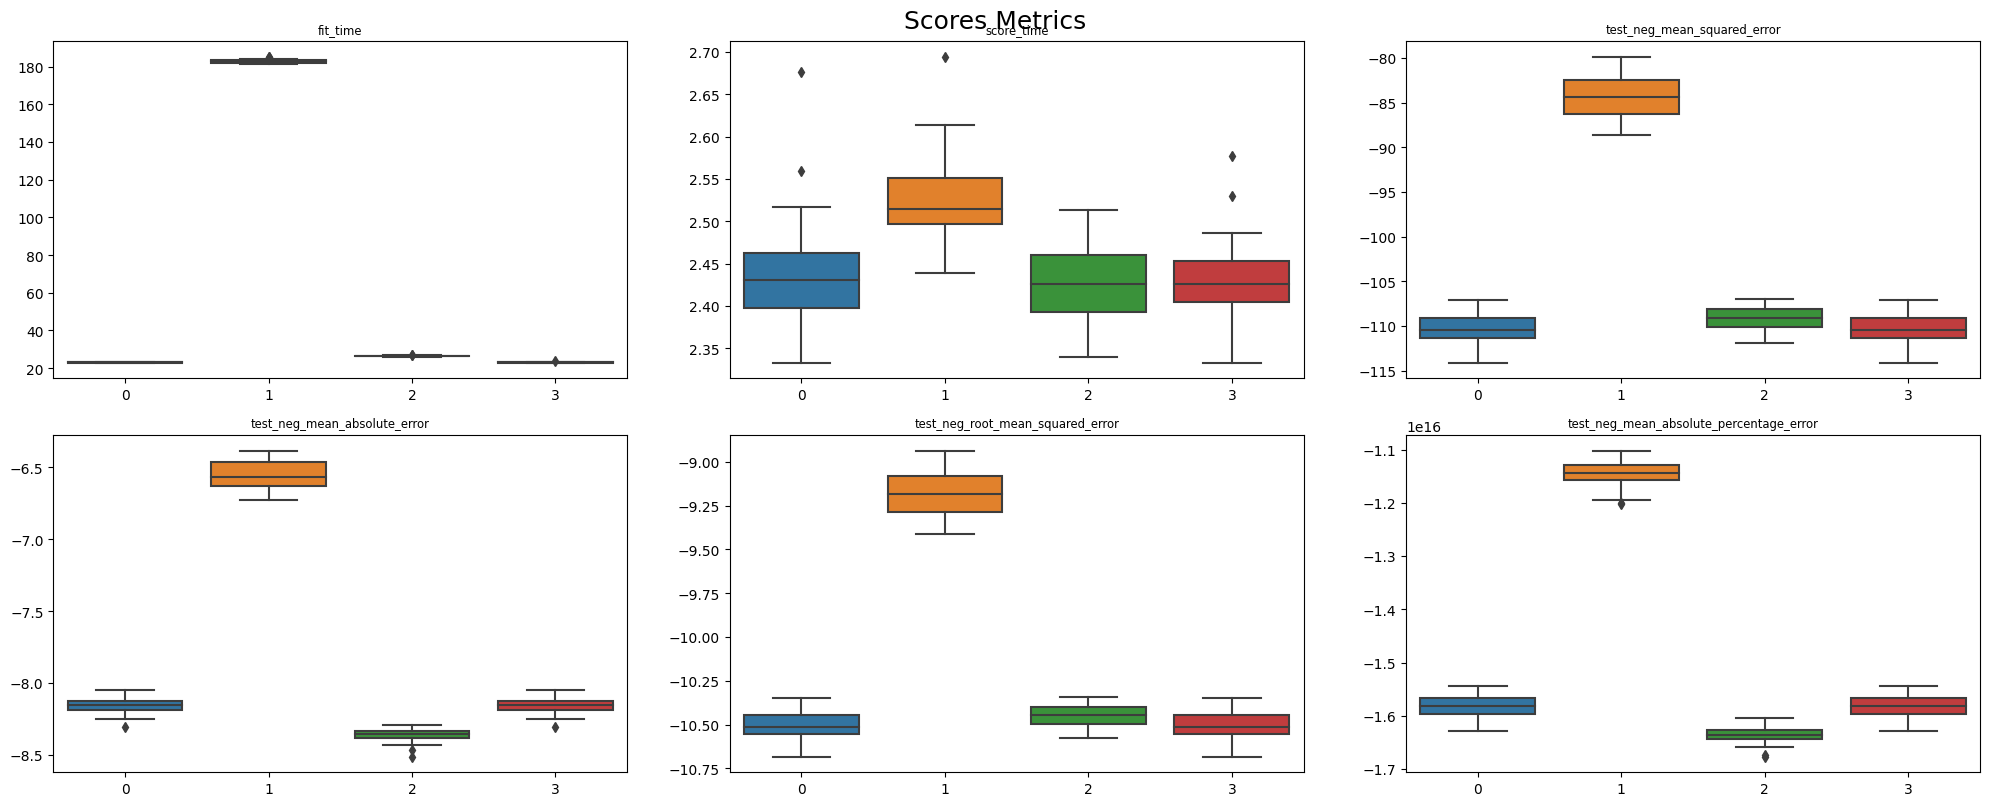

In [275]:
plt.figure(figsize=(20, 20))
plt.suptitle("Scores Metrics")
for i,col in enumerate(all_scores_df.columns, 1): 
    ax = plt.subplot(5,3,i) 
    sns.boxplot(all_scores_df[col])
    plt.title(col, fontsize='small')
    plt.tight_layout(w_pad=3) 

Vậy mô hình được chọn là: RandomForestRegression

In [242]:
completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('RandomForestRegression', RandomForestRegressor())])

comp_pipeline.fit(x_train, y_train)
y_train_pred = comp_pipeline.predict(x_train)

In [243]:
print(f'Train set: [MSE: {mean_squared_error(y_train, y_train_pred):.3f}, MAE: {mean_absolute_error(y_train, y_train_pred):.3f}]')
print(f'Test set: [MSE: {mean_squared_error(y_test, y_test_pred):.3f}, MAE: {mean_absolute_error(y_test, y_test_pred):.3f}]')

Train set: [MSE: 108.656, MAE: 8.093]
Test set: [MSE: 109.089, MAE: 8.093]


Có thể thấy độ lỗi cũng không khác gì mấy so với linear regression ở trường hợp bên trên.